In [1]:
#!ipcluster start -n 8 --engines=MPI --profile='mpi' # for parallel run: start the engines using terminal
from ipyparallel import Client
rc = Client(profile='mpi')

In [2]:
%%px
# Import the libraries

import os
import sys
import math
import numpy as np
import pyfftw as ft 
from mpi4py import MPIPI
import matplotlib
import matplotlib.pyplot as plt
import pyJHTDB
from pyJHTDB.dbinfo import isotropic1024coarse
from pyJHTDB import libJHTDB

from fft3d import FFT3Dfield_new
from EnergySpectrum import EnergySpectrum

In [3]:
%%px

Nx = isotropic1024coarse['nx']; Ny = isotropic1024coarse['ny']; Nz = isotropic1024coarse['nz']
Lx = isotropic1024coarse['lx']; Ly = isotropic1024coarse['ly']; Lz = isotropic1024coarse['lz']

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
nproc = comm.Get_size()
if(rank==0):
    print("n_proc = "+str(nproc))
    print("rank = "+str(rank))

# Computational Domain

nx=Nx//nproc; ny=Ny; nz=Nz
nz_half=nz//2
nek=int(math.sqrt(2.0)/3*Nx)
time = 0.0

chkSz = 32
slabs = nx//chkSz

[stdout:4] 
n_proc = 8
rank = 0


In [4]:
%%px

cacheEnstrophyData = False
loadEnstrophyFromCache = True

folder = "/home/idies/workspace/scratch"
filename = "enstrophy-isotropic1024coarse-"+str(rank)+"-(t="+str(time)+")"+".npz"
file = folder + "/" + filename

if(loadEnstrophyFromCache):
    comm.Barrier(); t1=MPI.Wtime()
    content = np.load(file)
    
    w2 = ft.zeros_aligned((nx,ny,nz), dtype='float32')
    
    if(int(content['nproc'])!=nproc):
        print("Unmatched number of processes. Must first pre-process to adequate number of process")
    w2[:,:,:] = content['w2']
    
    comm.Barrier(); t2=MPI.Wtime()
    if(rank==0):
        print("Finished loading")
        sys.stdout.write('Load from disk: {0:.2f} seconds\n'.format(t2-t1))

if(cacheEnstrophyData):
    
    comm.Barrier(); t1=MPI.Wtime()
    np.savez(file,w2=w2,nproc=nproc)
    comm.Barrier(); t2=MPI.Wtime()
    if(rank==0):
        sys.stdout.write('Caching the data: {0:.2f} seconds\n'.format(t2-t1))

[stdout:4] 
Finished loading
Load from disk: 73.94 seconds


In [5]:
%%px

avgOmega = np.average(w2)
avgOmegaGl=np.zeros(1,dtype='float32')

comm.Reduce([avgOmega,MPI.REAL],[avgOmegaGl,MPI.REAL],op=MPI.SUM)
avgOmega = avgOmegaGl[0]/nproc
avgOmega = comm.bcast(avgOmega, root=0)
sigma2_w = avgOmega

In [6]:
%%px 

minw2 = w2.min()
maxw2 = w2.max()

minwGl=np.zeros(nproc,dtype='float32')
maxwGl=np.zeros(nproc,dtype='float32')

comm.Allgather([minw2,MPI.REAL],[minwGl,MPI.REAL])
comm.Allgather([maxw2,MPI.REAL],[maxwGl,MPI.REAL])

minw2 = minwGl.min()
maxw2 = maxwGl.max()

comm.Barrier()

if rank==0:
    print("min w2 : "+str(minw2/avgOmega))
    print("min w2 : "+str(maxw2/avgOmega))

[stdout:4] 
min w2 : 9.42405779472e-08
min w2 : 460.221529152


For reference, at time $t=0.0$:

$\frac{\min_{x \in [0,2\pi]^3} \omega^2(x)}{\langle \omega^2\rangle} = 9.42406 \times 10^{-8} $

$\frac{\max_{x \in [0,2\pi]^3} \omega^2}{\langle \omega^2\rangle} = 460.222 $

In [7]:
%%px

chi = ft.zeros_aligned((nx,ny,nz), dtype='float32')

[output:4]

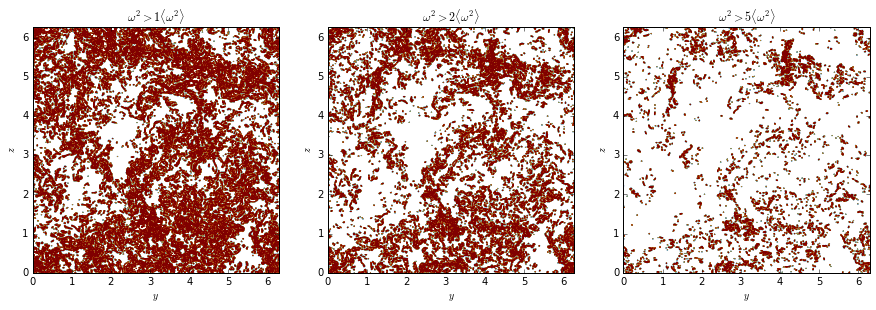

In [10]:
%%px 
%matplotlib inline

if(rank==0):
    plt.figure(figsize=(15,10))
    t = [1,2,5]#,7,10,20]
    for i in range(3):#6):
        chi[:,:,:] = 0
        chi[w2 > t[i]*sigma2_w] = 1
        
        slice0 = chi[0,:,:] 
        
        xlist = np.linspace(0,2*math.pi, Ny)
        ylist = np.linspace(0,2*math.pi, Nz)
        Y, Z = np.meshgrid(xlist, ylist)
        
        ax = plt.subplot(2,3,i+1)#plt.subplot(tt) 
        plt.contour(Y, Z, slice0)
        #plt.imshow(slice0)
        ax.set_title(r'$\omega^2>'+str(t[i])+r' \langle \omega^2\rangle $')
                
        plt.xlabel(r'$y$')
        plt.ylabel(r'$z$')
        plt.gca().set_aspect('equal', adjustable='box')
        
    plt.show()

[output:4]

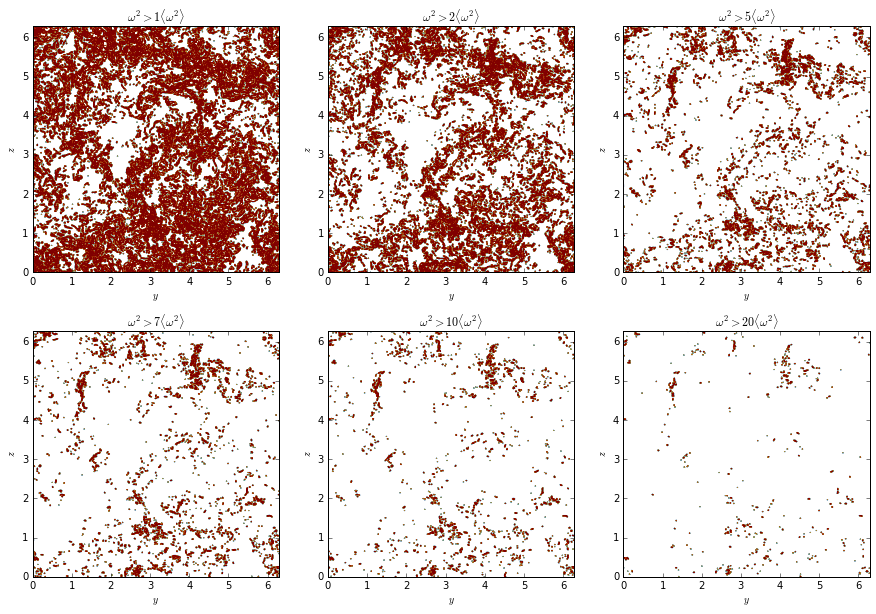

In [11]:
%%px 
%matplotlib inline

if(rank==0):
    plt.figure(figsize=(15,10))
    t = [1,2,5,7,10,20]
    for i in range(6):
        chi[:,:,:] = 0
        chi[w2 > t[i]*sigma2_w] = 1
        
        slice0 = chi[0,:,:] 
        
        xlist = np.linspace(0,2*math.pi, Ny)
        ylist = np.linspace(0,2*math.pi, Nz)
        Y, Z = np.meshgrid(xlist, ylist)
        
        ax = plt.subplot(2,3,i+1)#plt.subplot(tt) 
        plt.contour(Y, Z, slice0)
        #plt.imshow(slice0)
        ax.set_title(r'$\omega^2>'+str(t[i])+r' \langle \omega^2\rangle $')
                
        plt.xlabel(r'$y$')
        plt.ylabel(r'$z$')
        plt.gca().set_aspect('equal', adjustable='box')
        
    plt.show()

In [8]:
%%px 

fft = FFT3Dfield_new(nx,ny,nz,nproc,rank)

In [9]:
%%px
cchi = ft.zeros_aligned((nx,ny,1+(nz//2)), dtype='complex64')
corr = ft.zeros_aligned((nx,ny,nz),dtype='float32')

chi[:,:,:] = 0
chi[w2 > 5*sigma2_w] = 1

In [14]:
%%px

comm.Barrier(); t1=MPI.Wtime()

cchi[:,:,:] = fft.forward3Dfft(chi,nx,ny,nz,nproc,rank)

comm.Barrier(); t2=MPI.Wtime()
if(rank==0):
    sys.stdout.write('Calculate 3D spatial FFT: {0:.2f} seconds\n'.format(t2-t1))

[stdout:4] Calculate 3D spatial FFT: 57.18 seconds


In [15]:
%%px

comm.Barrier(); t1=MPI.Wtime()

tmp = cchi*(cchi.conj())

comm.Barrier(); t2=MPI.Wtime()
if(rank==0):
    sys.stdout.write('Calculate 2-point correlation via Fourier transform: {0:.2f} seconds\n'.format(t2-t1))

[stdout:4] Calculate 2-point correlation via Fourier transform: 25.37 seconds


In [16]:
%%px

comm.Barrier(); t1=MPI.Wtime()

corr[:,:,:] = fft.backward3Dfft(tmp,nx,ny,nz,nproc,rank)

comm.Barrier(); t2=MPI.Wtime()
if(rank==0):
    sys.stdout.write('Calculate 3D inverse spatial FFT: {0:.2f} seconds\n'.format(t2-t1))

[stdout:4] Calculate 3D inverse spatial FFT: 31.77 seconds


In [10]:
%%px

X = np.zeros((nx,ny,nz), dtype='float32')
Y = np.zeros((nx,ny,nz), dtype='float32')
Z = np.zeros((nx,ny,nz), dtype='float32')

r2 = np.zeros((nx,ny,nz), dtype='float32')
iCorr = np.zeros((nx,ny,nz), dtype='float32')

for i in range(nx):
    X[i,:,:] = (i+rank*nx)*isotropic1024coarse['dx']

for j in range(ny):
    Y[:,j,:] = j*isotropic1024coarse['dy']
    
for k in range(nz):
    Z[:,:,k] = k*isotropic1024coarse['dz']
    
r2[:,:,:] = X[:,:,:]**2+Y[:,:,:]**2+Z[:,:,:]**2

In [11]:
%%px

iCorr[:,:,:] = corr[:,:,:]

iCorr[:,512:1024,:] = 0.
iCorr[:,:,512:1024] = 0.

if(rank>=4):
    iCorr[:,:,:] = 0.

In [19]:
%%px

dx = isotropic1024coarse['dx']
ner = int(1024*np.sqrt(3))
rbins = np.linspace(-0.5*dx,2*np.pi*np.sqrt(3)+0.5*dx,ner+1)

r2rt = np.sqrt(r2)

comm.Barrier()

corrLoc,redges = np.histogram(r2rt,range=(0.5*dx,(ner+0.5)*dx),bins = rbins,weights=iCorr)

comm.Barrier()

In [20]:
%%px 

corrLoc=np.float32(corrLoc)
corrSum=np.zeros(ner,dtype='float32')
corrF=np.zeros(ner,dtype='float32') 

In [21]:
%%px 

comm.Barrier(); t1=MPI.Wtime()

comm.Reduce([corrLoc,MPI.REAL],[corrSum,MPI.REAL],op=MPI.SUM)

np.copyto(corrF,corrSum)

comm.Barrier(); t2=MPI.Wtime()

[output:4]

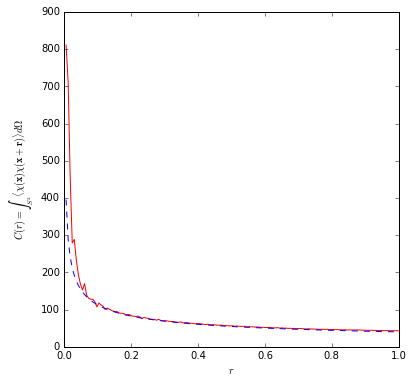

In [22]:
%%px

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

if rank==0:
    norm = np.sum(corrF)
    SIZE = 12
    rp=np.linspace(1*dx,ner*dx,ner)
    plt.figure(figsize=(6,6))
    plt.xlabel(r'$r$')
    plt.ylabel(r'$C(r) = \int_{S^2} \langle \chi({\bf x}) \chi({\bf x}+{\bf r}) \rangle d\Omega$')
    plt.xlim([0,1])
    
    plt.plot(rp,corrF*(rp**(-2)),'r',label='Unfiltered')
    plt.plot(rp,40*np.power(rp,-0.45),'b--')

[output:4]

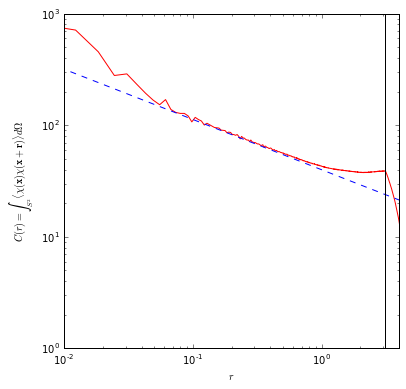

In [23]:
%%px

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

if rank==0:
    norm = np.sum(corrF)
    SIZE = 12
    rp=np.linspace(1*dx,ner*dx,ner)
    plt.figure(figsize=(6,6))
    
    plt.xlabel(r'$r$')
    plt.ylabel(r'$C(r) = \int_{S^2} \langle \chi({\bf x}) \chi({\bf x}+{\bf r}) \rangle d\Omega$')
    
    plt.xlim([0.01,4])
    plt.ylim([1,1000])
    
    plt.loglog(rp,corrF*(rp**(-2)),'r',label='Unfiltered')
    plt.loglog(rp,40*np.power(rp,-0.45),'b--')
    plt.axvline(x=np.pi,color='k')#,dashes=True)

In [24]:
%%px

chi2 = ft.zeros_aligned((nx,ny,nz), dtype='float32')
chi5 = ft.zeros_aligned((nx,ny,nz), dtype='float32')

cchi2 = ft.zeros_aligned((nx,ny,1+(nz//2)), dtype='complex64')
cchi5 = ft.zeros_aligned((nx,ny,1+(nz//2)), dtype='complex64')

corr2 = ft.zeros_aligned((nx,ny,nz), dtype='float32')
corr5 = ft.zeros_aligned((nx,ny,nz), dtype='float32')

In [25]:
%%px

chi2[:,:,:] = 0
chi2[w2 > 2*sigma2_w] = 1

chi5[:,:,:] = 0
chi5[w2 > 5*sigma2_w] = 1

comm.Barrier(); 

In [26]:
%%px

comm.Barrier(); t1=MPI.Wtime()

cchi2[:,:,:] = fft.forward3Dfft(chi2,nx,ny,nz,nproc,rank)
cchi5[:,:,:] = fft.forward3Dfft(chi5,nx,ny,nz,nproc,rank)

comm.Barrier(); t2=MPI.Wtime()
if(rank==0):
    sys.stdout.write('Calculate 3D spatial FFT: {0:.2f} seconds\n'.format(t2-t1))

[stdout:4] Calculate 3D spatial FFT: 99.71 seconds


In [27]:
%%px

comm.Barrier(); t1=MPI.Wtime()

#tmp = cchi*(cchi.conj())
tmp2 = cchi2*(cchi2.conj())
corr2[:,:,:]=fft.backward3Dfft(tmp2,nx,ny,nz,nproc,rank)

tmp5 = cchi5*(cchi5.conj())
corr5[:,:,:]=fft.backward3Dfft(tmp5,nx,ny,nz,nproc,rank)

comm.Barrier(); t2=MPI.Wtime()
if(rank==0):
    sys.stdout.write('Calculate 2-point correlation via Fourier transform: {0:.2f} seconds\n'.format(t2-t1))

[stdout:4] Calculate 2-point correlation via Fourier transform: 421.00 seconds


In [28]:
%%px 

iCorr2 = ft.zeros_aligned((nx,ny,nz), dtype='float32')
iCorr5 = ft.zeros_aligned((nx,ny,nz), dtype='float32')

In [29]:
%%px

iCorr2[:,:,:] = corr2[:,:,:]

iCorr2[:,512:1024,:] = 0.
iCorr2[:,:,512:1024] = 0.

iCorr5[:,:,:] = corr5[:,:,:]

iCorr5[:,512:1024,:] = 0.
iCorr5[:,:,512:1024] = 0.

if(rank>=4):
    iCorr[:,:,:] = 0.

In [30]:
%%px

dx = isotropic1024coarse['dx']
ner = int(1024*np.sqrt(3))
rbins = np.linspace(-0.5*dx,2*np.pi*np.sqrt(3)+0.5*dx,ner+1)

r2rt = np.sqrt(r2)

comm.Barrier()

corrLoc2,redges2 = np.histogram(r2rt,range=(0.5*dx,(ner+0.5)*dx),bins = rbins,weights=iCorr2)
corrLoc5,redges5 = np.histogram(r2rt,range=(0.5*dx,(ner+0.5)*dx),bins = rbins,weights=iCorr5)

comm.Barrier()

In [31]:
%%px 

corrLoc2=np.float32(corrLoc2)
corrSum2=np.zeros(ner,dtype='float32')
corrF2=np.zeros(ner,dtype='float32') 

corrLoc5=np.float32(corrLoc5)
corrSum5=np.zeros(ner,dtype='float32')
corrF5=np.zeros(ner,dtype='float32')

In [32]:
%%px 

comm.Barrier(); t1=MPI.Wtime()

comm.Reduce([corrLoc2,MPI.REAL],[corrSum2,MPI.REAL],op=MPI.SUM)
comm.Reduce([corrLoc5,MPI.REAL],[corrSum5,MPI.REAL],op=MPI.SUM)

np.copyto(corrF2,corrSum2)
np.copyto(corrF5,corrSum5)

comm.Barrier(); t2=MPI.Wtime()

In [33]:
%%px

if rank==0:
    rp=np.linspace(1*dx,ner*dx,ner)
    tempRp = rp[(rp>0.1)&(rp<1.0)]
    tempCorrF2 = corrF2[(rp>0.1)&(rp<1.0)]
    tempCorrF5 = corrF5[(rp>0.1)&(rp<1.0)]
    fit2 = np.polyfit(np.log(tempRp),np.log((tempCorrF2/corrF2[0])*(tempRp**(-2))),1)
    fit5 = np.polyfit(np.log(tempRp),np.log((tempCorrF5/corrF5[0])*(tempRp**(-2))),1)
    

In [34]:
%%px

if rank==0:
    print("t = 2*sigma_2: Linear fit [alpha A] = "+str(fit2))
    print("t = 5*sigma_2: Linear fit [alpha A] = "+str(fit5))

[stdout:4] 
t = 2*sigma_2: Linear fit [alpha A] = [-0.2239304   8.56225119]
t = 5*sigma_2: Linear fit [alpha A] = [-0.42907955  7.22947215]


[output:4]

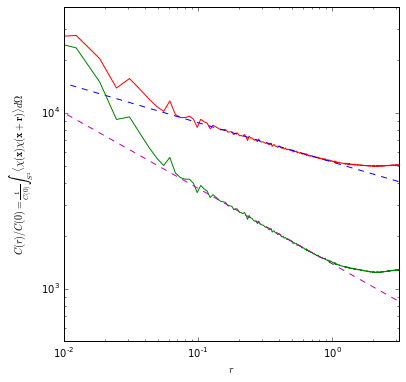

In [35]:
%%px

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

if rank==0:
    norm2 = np.sum(corrF2)
    norm5 = np.sum(corrF5)
    SIZE = 12
    rp=np.linspace(1*dx,ner*dx,ner)
    plt.figure(figsize=(6,6))
    
    plt.xlabel(r'$r$')
    plt.ylabel(r'$C(r)/C(0) = \frac{1}{C(0)}\int_{S^2} \langle \chi({\bf x}) \chi({\bf x}+{\bf r}) \rangle d\Omega$')
    
    plt.xlim([0.01,np.pi])
    plt.ylim([5*10**2,4*10**4])
    
    plt.loglog(rp,(corrF2/corrF2[0])*(rp**(-2)),'r',label='Unfiltered')
    plt.loglog(rp,np.exp(fit2[1])*(rp**(fit2[0])),'b--')
    
    plt.loglog(rp,(corrF5/corrF5[0])*(rp**(-2)),'g',label='Unfiltered')
    plt.loglog(rp,np.exp(fit5[1])*(rp**(fit5[0])),'m--')
    
    #plt.axvline(x=np.pi,color='k')

In [14]:
%%px

fft = FFT3Dfield_new(nx,ny,nz,nproc,rank)

X = np.zeros((nx,ny,nz), dtype='float32')
Y = np.zeros((nx,ny,nz), dtype='float32')
Z = np.zeros((nx,ny,nz), dtype='float32')

r2 = np.zeros((nx,ny,nz), dtype='float32')

chi = ft.zeros_aligned((nx,ny,nz), dtype='float32')
cchi = ft.zeros_aligned((nx,ny,1+(nz//2)), dtype='complex64')
corr = ft.zeros_aligned((nx,ny,nz),dtype='float32')
iCorr = np.zeros((nx,ny,nz), dtype='float32')

corrLoc=np.float32(corrLoc)
corrSum=np.zeros(ner,dtype='float32')
corrF=np.zeros(ner,dtype='float32') 

In [15]:
%%px 
%matplotlib inline

for i in range(nx):
    X[i,:,:] = (i+rank*nx)*isotropic1024coarse['dx']

for j in range(ny):
    Y[:,j,:] = j*isotropic1024coarse['dy']
    
for k in range(nz):
    Z[:,:,k] = k*isotropic1024coarse['dz']
    
r2[:,:,:] = X[:,:,:]**2+Y[:,:,:]**2+Z[:,:,:]**2

dx = isotropic1024coarse['dx']
ner = int(1024*np.sqrt(3))
rbins = np.linspace(-0.5*dx,2*np.pi*np.sqrt(3)+0.5*dx,ner+1)

r2rt = np.sqrt(r2)

if(rank==0):
    rp=np.linspace(1*dx,ner*dx,ner)
    tempRp = rp[(rp>0.1)&(rp<1.0)]
    plt.figure(figsize=(6,6))
    plt.xlabel(r'$r$')
    plt.ylabel(r'$C(r) = \int_{S^2} \langle \chi({\bf x}) \chi({\bf x}+{\bf r}) \rangle d\Omega$')
    plt.xlim([10**(-2),np.pi])
    plt.ylim([5*10**2,4*10**4])

t = [1,2,3,4,5,6]
c = ['r','g','b','c','y','m']

for i in range(6):
    chi[:,:,:] = 0
    chi[w2 > t[i]*sigma2_w] = 1
    comm.Barrier();
    
    cchi[:,:,:] = fft.forward3Dfft(chi,nx,ny,nz,nproc,rank)
    comm.Barrier();
    
    tmp = cchi*(cchi.conj())
    comm.Barrier(); 
    
    corr[:,:,:] = fft.backward3Dfft(tmp,nx,ny,nz,nproc,rank)
    comm.Barrier(); 
    
    iCorr[:,:,:] = corr[:,:,:]
    iCorr[:,512:1024,:] = 0.
    iCorr[:,:,512:1024] = 0.
    
    if(rank>=4):
        iCorr[:,:,:] = 0.
    comm.Barrier()
    
    corrLoc,redges = np.histogram(r2rt,range=(0.5*dx,(ner+0.5)*dx),bins = rbins,weights=iCorr)
    comm.Barrier()
    
    comm.Reduce([corrLoc,MPI.REAL],[corrSum,MPI.REAL],op=MPI.SUM)
    np.copyto(corrF,corrSum)
    comm.Barrier()
    
    if rank==0:
        tempCorrF = corrF[(rp>0.1)&(rp<1.0)]
        fit = np.polyfit(np.log(tempRp),np.log((tempCorrF/corrF[0])*(tempRp**(-2))),1)
        
        plt.loglog(rp,(corrF/corrF[0])*(rp**(-2)),c[i],label=r'\omega^2 > '+str())
        plt.loglog(rp,np.exp(fit[1])*(rp**(fit2[0])),'k--')
        
    comm.Barrier()
        
comm.Barrier()
if rank==0:
    plt.show()

KeyboardInterrupt: 